In [1]:
import os
from itertools import count

import shapefile
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import geopandas
import osmnx as ox
import pandas as pd
from tqdm.auto import tqdm
from libpysal.cg import voronoi_frames
import momepy
import math
import shapely
shapely.speedups.disable()

import seaborn as sns

sns.set_theme(context='poster', style="whitegrid")

DATA = "data"

/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
G = nx.read_gpickle(os.path.join(DATA, "spiw_peripheral_bike_and_investmap.gpickle"))
G=G.to_undirected()

In [64]:
G_nodes, G_streets = ox.graph_to_gdfs(G)

G_nodes = G_nodes.to_crs(epsg=2177)
G_streets = G_streets.to_crs(epsg=2177)

In [65]:
G_streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 116896 entries, (95584835, 6152142174, 0) to (1006844, 1006845, 7979)
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     108566 non-null  object  
 1   oneway    100574 non-null  object  
 2   lanes     11977 non-null   object  
 3   ref       2170 non-null    object  
 4   name      34139 non-null   object  
 5   highway   100574 non-null  object  
 6   maxspeed  18895 non-null   object  
 7   length    108904 non-null  float64 
 8   type      116896 non-null  object  
 9   geometry  116896 non-null  geometry
 10  access    1891 non-null    object  
 11  bridge    760 non-null     object  
 12  junction  531 non-null     object  
 13  service   14067 non-null   object  
 14  width     518 non-null     object  
 15  tunnel    796 non-null     object  
 16  x         7992 non-null    float64 
 17  y         7992 non-null    float64 
 18  mm_len    7992

In [66]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 5):
    display(G_streets['type'].value_counts(dropna=False))

all_road            107423
bike_path             7992
closest_crossing      1481
Name: type, dtype: int64

In [67]:
G_roads_OSM = G_streets[(G_streets['type'] == 'all_road')]

In [68]:
G_roads_OSM.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 107423 entries, (95584835, 6152142174, 0) to (9444426531, 9444426534, 0)
Data columns (total 19 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   osmid     100574 non-null  object  
 1   oneway    100574 non-null  object  
 2   lanes     11977 non-null   object  
 3   ref       2170 non-null    object  
 4   name      34139 non-null   object  
 5   highway   100574 non-null  object  
 6   maxspeed  18895 non-null   object  
 7   length    107423 non-null  float64 
 8   type      107423 non-null  object  
 9   geometry  107423 non-null  geometry
 10  access    1891 non-null    object  
 11  bridge    760 non-null     object  
 12  junction  531 non-null     object  
 13  service   14067 non-null   object  
 14  width     518 non-null     object  
 15  tunnel    796 non-null     object  
 16  x         0 non-null       float64 
 17  y         0 non-null       float64 
 18  mm_len    0

In [69]:
highway_count = G_roads_OSM['highway'].value_counts(dropna=False)

with pd.option_context('display.max_rows', 100, 'display.max_columns', 5):
    display(highway_count)

service                                  34238
residential                              17918
track                                    14157
path                                     12036
tertiary                                  7885
NaN                                       6849
living_street                             2678
secondary                                 2600
cycleway                                  2399
unclassified                              2101
primary                                    880
[track, residential]                       511
[path, service]                            499
[path, cycleway]                           483
[track, service]                           457
[track, path]                              424
[residential, service]                     272
pedestrian                                 140
secondary_link                             104
primary_link                                98
tertiary_link                               81
[residential,

In [70]:
def generalize_highway(highway):
    if isinstance(highway, list):
        highway_types = highway_count[highway_count.index.isin(highway)]
        generalized_type = highway_types.index[highway_types.argmax()]
    elif highway_count[highway] < 50:
         return 'other'
    else:
        return highway


In [71]:
G_roads_OSM['generalized_highway'] = G_roads_OSM['highway'].apply(lambda h: generalize_highway(h))
G_roads_OSM['generalized_highway'] = G_roads_OSM['generalized_highway'].fillna('other')

/usr/local/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [72]:
with pd.option_context('display.max_rows', 100, 'display.max_columns', 5):
    display(G_roads_OSM['generalized_highway'].value_counts(dropna=False))

service           34238
residential       17918
track             14157
path              12036
other             10108
tertiary           7885
living_street      2678
secondary          2600
cycleway           2399
unclassified       2101
primary             880
pedestrian          140
secondary_link      104
primary_link         98
tertiary_link        81
Name: generalized_highway, dtype: int64

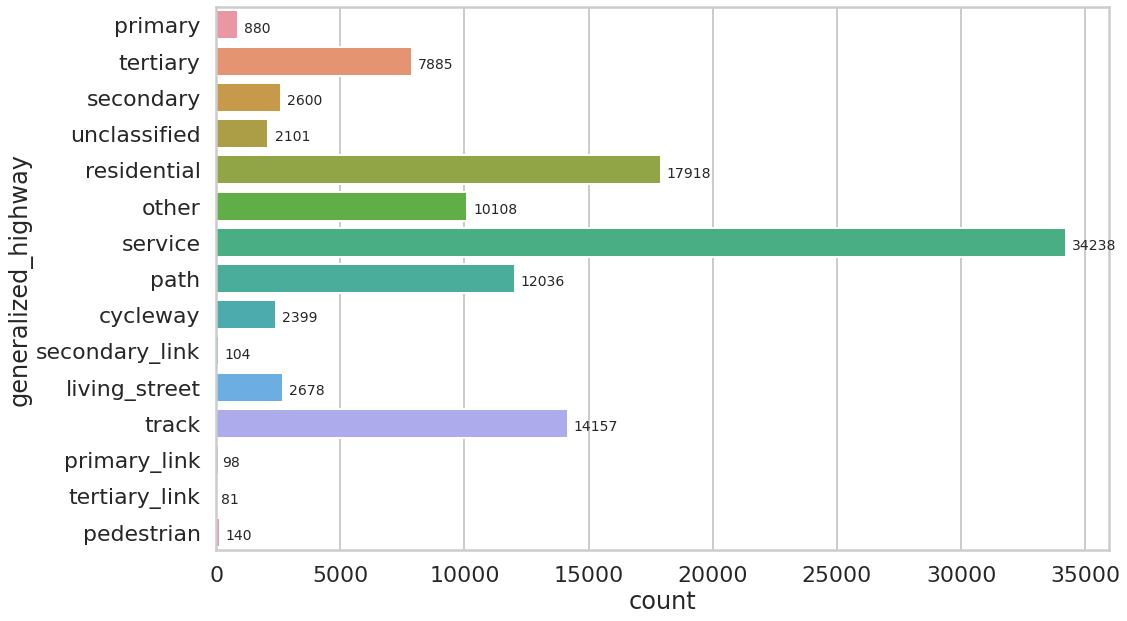

In [80]:
fix, ax = plt.subplots(figsize=(16, 10))
sns.countplot(y='generalized_highway', data=G_roads_OSM, ax=ax)

y_offset = 0.2
for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height()/2 + y_offset
    value = f'{p.get_width():.0f}'
    x_offset = math.log(len(value)) * 700
    _x += x_offset
    ax.text(_x, _y, value, ha="center", fontsize=14) 

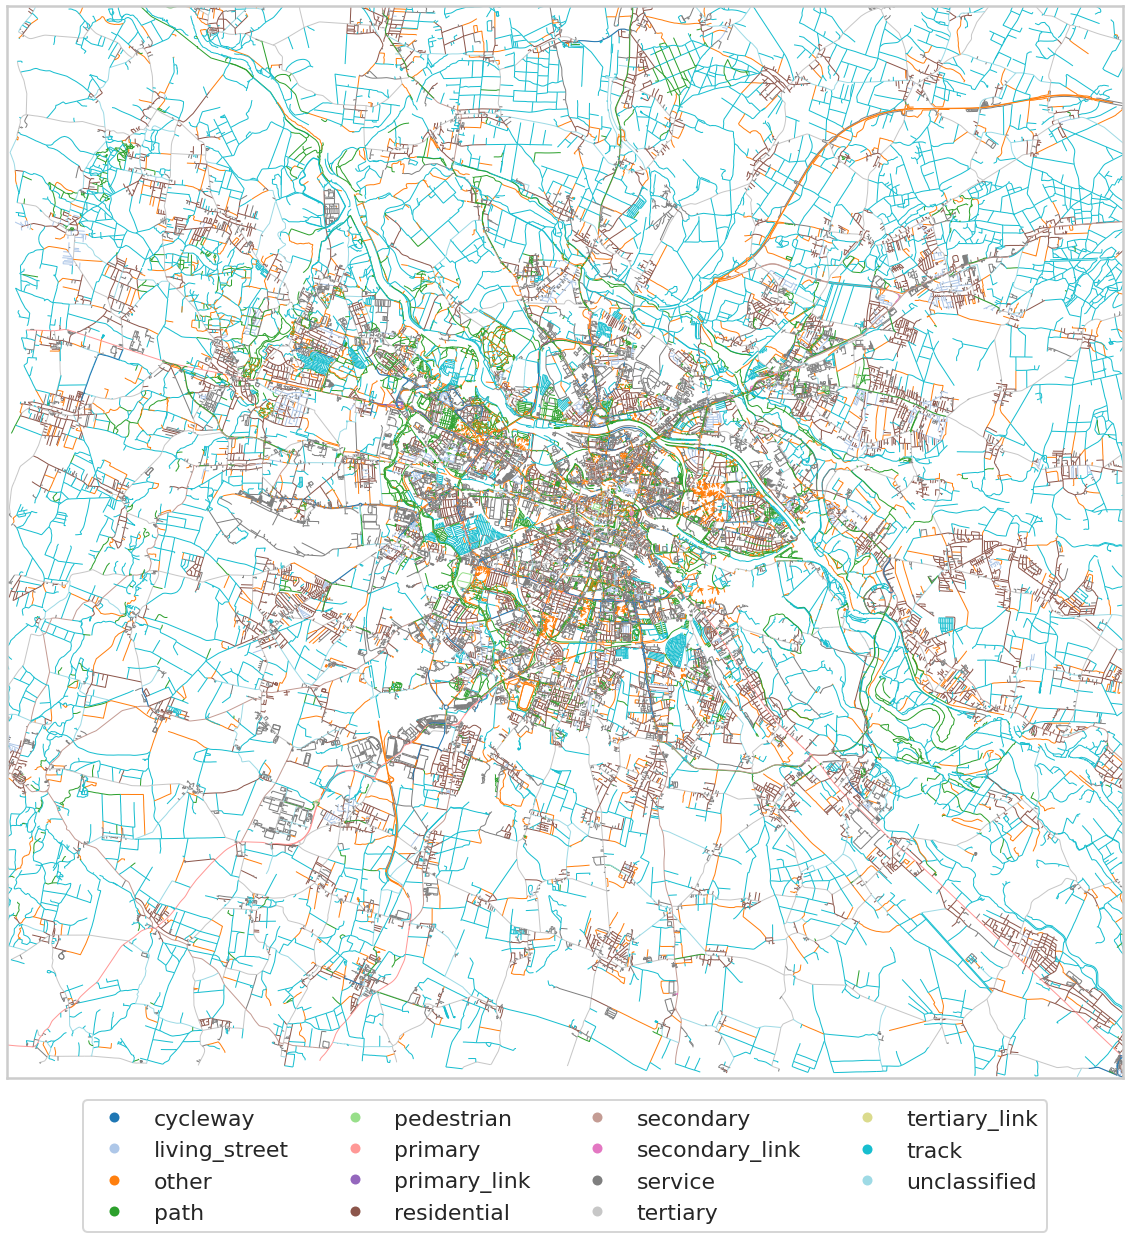

In [96]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot()

G_roads_OSM.plot(column='generalized_highway', linewidth=1, ax=ax, legend=True, cmap='tab20',
                 legend_kwds={'bbox_to_anchor': (0.5, -0.01), 'ncol': 4, 'loc': 'upper center'})

ax.set_ylim(bottom=5.6461e6, top=5.6803e6)
ax.set_xlim(left=6.4134e6, right=6.449e6)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
# cx.add_basemap(ax=ax, crs=G_nodes.crs.to_string(), source=cx.providers.CartoDB.Voyager)
plt.savefig('image/path_type.png', dpi=400)